# Euclid Q1: MER catalogs

## Learning Goals

By the end of this tutorial, you will:
- Understand the basic characteristics of Euclid Q1 MER catalogs.
- What columns are available in the MER catalog.
- How to query with ADQL in the MER catalog.
- How to make a simple color-magnitude diagram with the data.

## Introduction

Euclid launched in July 2023 as a European Space Agency (ESA) mission with involvement by NASA.
The primary science goals of Euclid are to better understand the composition and evolution of the dark Universe.
The Euclid mission is providing space-based imaging and spectroscopy as well as supporting ground-based imaging to achieve these primary goals.
These data will be archived by multiple global repositories, including IRSA, where they will support transformational work in many areas of astrophysics.

Euclid Quick Release 1 (Q1) consists of consists of ~30 TB of imaging, spectroscopy, and catalogs covering four non-contiguous fields:
Euclid Deep Field North (22.9 sq deg), Euclid Deep Field Fornax (12.1 sq deg), Euclid Deep Field South (28.1 sq deg), and LDN1641.

Among the data products included in the Q1 release are the three MER catalogs: the final catalog, the morphology catalog, and the cutouts catalog.
This notebook provides an introduction to the MER final catalog.
Each entry is a single source with associated photometry from the multiwavelength MER Mosaics (VIS, Y, J, H, and any accompanying external ground-based measurements), along with other basic measurements, like size and shape.
If you have questions about this notebook, please contact the [IRSA helpdesk](https://irsa.ipac.caltech.edu/docs/help_desk.html).

## Imports

```{important}
We rely on ``astroquery`` features that have been recently added, so please make sure you have version v0.4.10 or newer installed.
```

In [1]:
# Uncomment the next line to install dependencies if needed
# !pip install numpy matplotlib 'astroquery>=0.4.10'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from astroquery.ipac.irsa import Irsa

## 1. Download MER catalog from IRSA directly to this notebook

First, have a look at what Euclid catalogs are available. With the ``list_catalogs`` functionality, we'll receive a list of the name of the catalogs as well as their brief desciption.

In [3]:
Irsa.list_catalogs(filter='euclid')

{'euclid.tileid_association_q1': 'Euclid Q1 TILEID to Observation ID Association Table',
 'euclid.objectid_spectrafile_association_q1': 'Euclid Q1 Object ID to Spectral File Association Table',
 'euclid.observation_euclid_q1': 'Euclid Q1 CAOM Observation Table',
 'euclid.plane_euclid_q1': 'Euclid Q1 CAOM Plane Table',
 'euclid.artifact_euclid_q1': 'Euclid Q1 CAOM Artifact Table',
 'euclid_q1_mer_catalogue': 'Euclid Q1 MER Catalog',
 'euclid_q1_mer_morphology': 'Euclid Q1 MER Morphology',
 'euclid_q1_mer_cutouts': 'Euclid Q1 MER Cutouts',
 'euclid_q1_phz_photo_z': 'Euclid Q1 PHZ Photo-z Catalog',
 'euclid_q1_phz_star_sed': 'Euclid Q1 PHZ Star SED Catalog',
 'euclid_q1_phz_galaxy_sed': 'Euclid Q1 PHZ Galaxy SED Catalog',
 'euclid_q1_phz_classification': 'Euclid Q1 PHZ Classification Catalog',
 'euclid_q1_phz_qso_physical_parameters': 'Euclid Q1 PHZ QSO Physical Parameters Catalog',
 'euclid_q1_phz_nir_physical_parameters': 'Euclid Q1 PHZ NIR Physical Parameters Catalog',
 'euclid_q1_phz_

### Choose the Euclid MER table

In [4]:
table_mer = 'euclid_q1_mer_catalogue'

### Learn some information about the MER catalog:
- How many columns are there?
- List the column names

In [5]:
columns_info = Irsa.list_columns(catalog=table_mer)
print(len(columns_info))

477


In [6]:
columns_info

{'object_id': 'Euclid unique source identifier',
 'ra': 'Source barycenter RA coordinate (SExtractor ALPHA_J2000) decimal degrees',
 'dec': 'Source barycenter DEC coordinate (SExtractor DELTA_J2000) decimal degrees',
 'right_ascension_psf_fitting': 'Source RA coordinate derived by the PSF-fitting photometry method',
 'declination_psf_fitting': 'Source DEC coordinate derived by the PSF-fitting photometry method',
 'segmentation_map_id': 'Source ID in the associated segmentation map',
 'vis_det': 'Flag to indicate if the source is detected in the VIS mosaic (1) or is only detected in the NIR mosaic (0)',
 'flux_vis_1fwhm_aper': 'VIS band source aperture photometry flux (1 FWHM diameter) on PSF-matched images',
 'flux_vis_2fwhm_aper': 'VIS band source aperture photometry flux (2 FWHM diameter) on PSF-matched images',
 'flux_vis_3fwhm_aper': 'VIS band source aperture photometry flux (3 FWHM diameter) on PSF-matched images',
 'flux_vis_4fwhm_aper': 'VIS band source aperture photometry flux 

```{tip}
The MER catalog contains 476 columns, below are a few highlights:

- object_id
- flux_vis_psf, mer.flux_y_templfit,flux_j_templfit, mer.flux_h_templfit
- fwhm
```

### Define the following ADQL query to find the first 10k stars in the MER catalog

Since we are just using the MER catalog alone, it does not have a column for classification.
We can use the `point_like_flag = 1` or `point_like_prob > 0.99` for stars.

Set all the fluxes to be greater than 0 so the object is detected in all four Euclid MER mosaic images.

In [7]:
adql_stars = ("SELECT TOP 10000 mer.object_id, mer.ra, mer.dec, mer.flux_vis_psf, mer.fluxerr_vis_psf, "
              "mer.flux_y_templfit,mer.fluxerr_y_templfit, mer.flux_j_templfit, mer.fluxerr_j_templfit, "
              "mer.flux_h_templfit, mer.fluxerr_h_templfit, mer.point_like_prob, mer.extended_prob "
              f"FROM {table_mer} AS mer "
              "WHERE  mer.flux_vis_psf > 0 "
              "AND mer.flux_y_templfit > 0 "
              "AND mer.flux_j_templfit > 0 "
              "AND mer.flux_h_templfit > 0 "
              "AND mer.point_like_flag = 1 ")

We can run the query with the TAP service, and then look at some of the results.

In [8]:
result_stars = Irsa.query_tap(adql_stars).to_table()
result_stars[:5]

object_id,ra,dec,flux_vis_psf,fluxerr_vis_psf,flux_y_templfit,fluxerr_y_templfit,flux_j_templfit,fluxerr_j_templfit,flux_h_templfit,fluxerr_h_templfit,point_like_prob,extended_prob
,deg,deg,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,
int64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
2744114360659252222,274.41143605,65.92522229,18.06845093,0.05907947198,40.79600143,0.3914021254,51.24997711,0.3443856239,50.90077591,0.3428814411,0.9834615588,--
2748261452659161963,274.82614525,65.91619631,20.08031464,0.05796840787,62.98400116,0.402326107,72.14587402,0.40771842,73.11473083,0.4038525522,0.9726842046,--
2753614816659165447,275.36148169,65.91654475,9.404380798,0.05080717802,72.25162506,0.4641048908,90.76555634,0.4693774283,92.41596222,0.4599996209,0.9804971218,--
2751521116659187938,275.15211165,65.91879386,8.089911461,0.029209584,31.106287,0.2833509445,37.05817795,0.2450377196,36.19960022,0.2430710047,0.9785846472,--
2746833910659142932,274.68339103,65.91429329,33.57302475,0.1107933447,129.1610565,0.8352462053,157.439621,0.7156305909,164.0423431,0.8300358057,0.9811390638,--


## 2. Make a color-magnitude diagram using the catalogs pulled from IRSA

- Convert from flux in uJy to magnitudes using the zero point correction
- Convert the error bars to magnitudes as well
- Plot the color-magnitude diagram

Text(0.5, 1.0, '10k Stars in MER catalog -- IRSA')

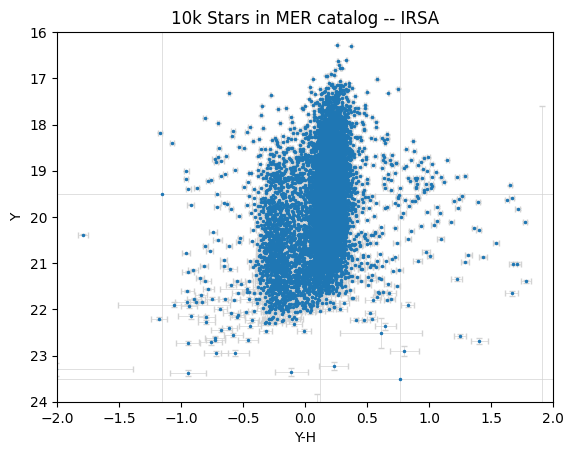

In [9]:
mag_y = -2.5 * np.log10(result_stars["flux_y_templfit"]) + 23.9
mag_h = -2.5 * np.log10(result_stars["flux_h_templfit"]) + 23.9

x = mag_y - mag_h  # Y - H
y = mag_y

xerr = (2.5 / np.log(10) * np.sqrt((result_stars["fluxerr_y_templfit"] / result_stars["flux_y_templfit"])**2
                                   + (result_stars["fluxerr_h_templfit"] / result_stars["flux_h_templfit"])**2))
yerr = (2.5 / np.log(10) * (result_stars["fluxerr_y_templfit"] / result_stars["flux_y_templfit"]))

plt.errorbar(x, y, xerr=xerr, yerr=yerr,
             fmt='o', markersize=1.5, ecolor='lightgrey', elinewidth=0.5, capsize=2)

plt.xlabel('Y-H')
plt.ylabel('Y')
# Note that these limits exclude a handful of points with large error bars.
plt.xlim(-2, 2)
plt.ylim(24, 16)
plt.title('10k Stars in MER catalog -- IRSA')

## About this Notebook

**Author**: Tiffany Meshkat, Anahita Alavi, Anastasia Laity, Andreas Faisst, Brigitta Sipőcz, Dan Masters, Harry Teplitz, Jaladh Singhal, Shoubaneh Hemmati, Vandana Desai

**Updated**: 2025-04-09

**Contact:** [the IRSA Helpdesk](https://irsa.ipac.caltech.edu/docs/help_desk.html) with questions or reporting problems.